# Monet Painting Project using GANs


In this project we need to build a GAN that generates 7,000 to 10,000 Monet-style images.
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. 
The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Data Source: https://www.kaggle.com/competitions/gan-getting-started/overview

For this project we would use Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. Image-to-image translation is a class of vision and graphics problems where the goal is to learn the mapping between an input image and an output image using a training set of aligned image pairs. In this project, paired training data is not available. So we need to translate an image from a source domain X to a target domain Y in the absence of paired examples. We need to learn a mapping G:X→Y such that the distribution of images from G(X) is indistinguishable from the distribution Y using an adversarial loss. We need to couple this mapping with an inverse mapping F:Y→X and introduce a cycle consistency loss to push F(G(X))≈X.

The dataset contains:
* monet directories that contain Monet paintings (we need to use Monet images to train our model)
* photo directories that contain photos (we need to add Monet-style to these images).
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

We will refer https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial, https://keras.io/examples/generative/cyclegan/
and https://arxiv.org/pdf/1703.10593 for this project.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models, losses, optimizers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE


2024-05-20 20:21:55.319672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 20:21:55.319759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 20:21:55.321407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1


We will use the TFRecord dataset and load the filenames.

In [2]:
# Loading file names
MONET_FILENAMES= tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))
PHOTO_FILENAMES= tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


We need to scale the images to [-1,1] scale (since we would be using tanh activation function) by dividing by 127.5 and then subtracting 1.
We are using 256x256 RGB image so we need to set channels to 3. 
read_tfrecord function is used to parse a single record from a TFRecord file and decode the image data contained within it.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Next, we will extract the images from the files and load the photo and monet datasets. load_dataset is used to load data from TFRecord files.

In [4]:
# function to extract the image from the files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
# loading in our datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Now, let us visualize a Photo and a Monet painting example.

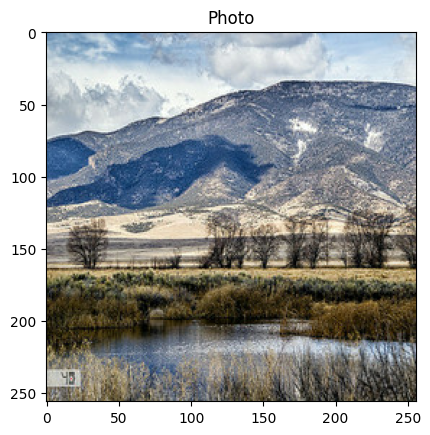

In [7]:
# Photo example
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

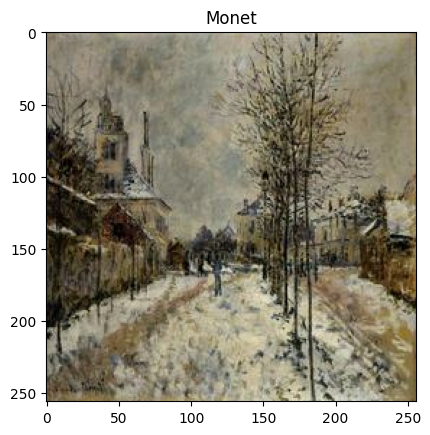

In [8]:
# Monet painting example
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

We will create downsample method to reduce the width and height of the input image. We will use 2D convolution layer with stride=2 so that the filter is applied to every other pixel and the height and the weight are reduced. We will use keras.initializers.RandomNormal() to draw samples from a normal distribution for given mean and standard deviation. We will use Instance Normalization so that the style and distribution of features across samples is preserved. Instance normalization operates independently on each sample in a batch, allowing the normalization to adapt to the statistics of each individual sample.  We will omit the bias terms, to reduce the number of parameters in the model, to reduce model complexity.

In [9]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        model.add(tf.keras.layers.GroupNormalization())  # Instance Normalization

    model.add(tf.keras.layers.LeakyReLU(0.2))

    return model

We will create upsample method to increase the image dimensions. tf.keras.layers.UpSampling2D layer upsamples the input feature and using size as (2,2) will double the size of the input along both dimensions. We will use LeakyReLU (Rectified Linear Unit) activation function to introduce non-linearity to the network to learn complex patterns.

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(layers.UpSampling2D((2,2)))
    model.add(layers.Conv2D(filters, size, strides=1, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(tf.keras.layers.GroupNormalization())              
    model.add(layers.LeakyReLU(0.2))
    if apply_dropout:
        model.add(layers.Dropout(0.5))

    return model

We use a UNET architecture for generator function. This includes an encoder-decoder structure with skip connections.The encoder downsamples the input image to extract features, while the decoder upsamples the features to generate the output image. Skip connections between corresponding encoder and decoder layers help preserve details during the translation process.
The generator first downsamples the input image and then upsamples while establishing long skip connections to solve vanishing gradient problem. We concatenate the output of the downsample layer to the upsample layer.

In [11]:
# Generator creation
OUTPUT_CHANNELS = 3
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(256, 4),
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    up_stack = [
        upsample(512, 4), 
        upsample(512, 4), 
        upsample(256, 4), 
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Let us try to call monet_generator() function. The generated Monet style image does not show Monet style image since our generators are not trained.

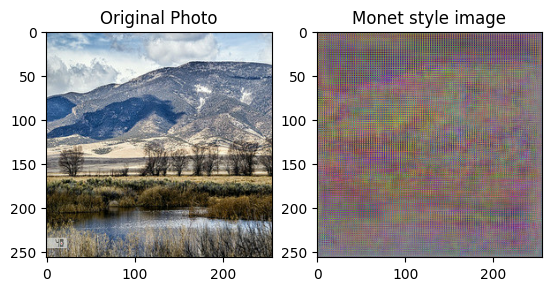

In [14]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet style image")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Building the CycleGAN model
During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.
For CycleGAN, we need to calculate different kinds of losses for the generators and discriminators.We will perform the following steps here:
1. Pass real images through the generators and get the generated images
2. Pass the generated images back to the generators to check if we can predict the original image from the generated image.
3. Do an identity mapping of the real images using the generators.
4. Pass the generated images in 1) to the corresponding discriminators.
5. Calculate the generators total loss (adversarial + cycle + identity)
6. Calculate the discriminators loss
7. Update the weights of the generators
8. Update the weights of the discriminators
9. Return the losses in a dictionary       

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Defining loss functions
The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [16]:
# Define the loss function for the discriminators
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [17]:
# Define the loss function for the generators
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Training the CycleGAN
Let's compile our model. Since we used tf.keras.Model to build our CycleGAN, we can just use the fit function to train our model.

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=8
)

Epoch 1/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4363s 14s/step - monet_disc_loss: 0.6478 - monet_gen_loss: 5.2009 - photo_disc_loss: 0.6616 - photo_gen_loss: 5.1802 - loss: 0.0000e+00
Epoch 2/8


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 4353s 14s/step - monet_disc_loss: 0.6052 - monet_gen_loss: 4.2797 - photo_disc_loss: 0.6479 - photo_gen_loss: 4.1648 - loss: 0.0000e+00
Epoch 3/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4343s 14s/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.8543 - photo_disc_loss: 0.6520 - photo_gen_loss: 3.6451 - loss: 0.0000e+00
Epoch 4/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4375s 15s/step - monet_disc_loss: 0.5761 - monet_gen_loss: 3.6296 - photo_disc_loss: 0.6458 - photo_gen_loss: 3.4442 - loss: 0.0000e+00
Epoch 5/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4415s 15s/step - monet_disc_loss: 0.5405 - monet_gen_loss: 3.5648 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.2812 - loss: 0.0000e+00
Epoch 6/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4426s 15s/step - monet_disc_loss: 0.5331 - monet_gen_loss: 3.5799 - photo_disc_loss: 0.6213 - photo_gen_loss: 3.2769 - loss: 0.0000e+00
Epoch 7/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 4535s 15s/step - monet_disc_loss: 0.5451 - monet_gen_loss: 3.4715 - photo_disc_loss: 0.6100 - ph

## Results
Now let us Visualize Monet style images generated from input photos.

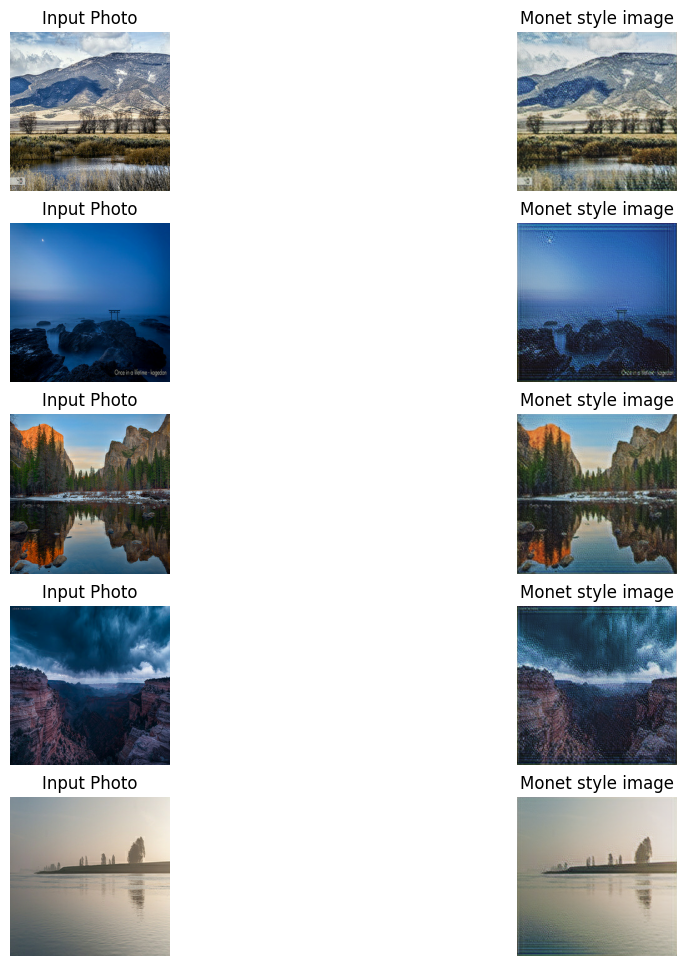

In [23]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet style image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Conclusion

When the learning rate was 2e-4 and number of epochs was 10 the model was taking a long time to process. So, we increased the learning rate to 0.001 and reduced the number of epochs to 5. But then the Monet style images looked exactly like Input photos. Finally, we changed the learning rate to 2e-4 and set the number of epochs to 8 and upon carefully looking at the Monet style images noticed that the input photos have started becoming like Monet paintings. 
If we further increase the number of epochs the generated Monet style images will be more like original Monet paintings but it will significantly increase the processing time. 

In [24]:
# #Creating directoy for submission
# import os
# from PIL import Image

# # Create a directory named "images" in the parent directory
# os.makedirs("../images", exist_ok=True)

# # Verify if the directory is created
# if os.path.exists("../images"):
#     print("Directory 'images' created successfully.")
# else:
#     print("Failed to create directory 'images'.")

In [25]:
# import PIL
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [26]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")